# Deep Learning & Art: Neural Style Transfer

## Packages
Run the following code cell to import the necessary packages and dependencies you will need to perform Neural Style Transfer.

In [1]:
pip install ipywidgets 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import pprint
from os import listdir
from os.path import isfile, join
import re
import ipywidgets as wd
from tqdm.notebook import trange, tqdm
%matplotlib inline

## Problem Statement
Neural Style Transfer (NST) merges two images, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S.

## Transfer Learning
Neural Style Transfer (NST) is built upon a previously trained convolutional network. The idea of using a network trained on a different task and applying it to a new task is called transfer learning.

We will use the VGG-19 network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers).

In [3]:
# Checking if the GPU is available
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False)


vgg.trainable = False
pp.pprint(vgg)

## Neural Style Transfer (NST)

We will be build the Neural Style Transfer (NST) algorithm in three steps:

1. The content cost function $J_{content}(C,G)$
2. The style cost function $J_{style}(S,G)$
3. The final result $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$.

### 1 - Content Cost

#### Goal
The goal of NST is to match the content of the generated image G and content image C.  


The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


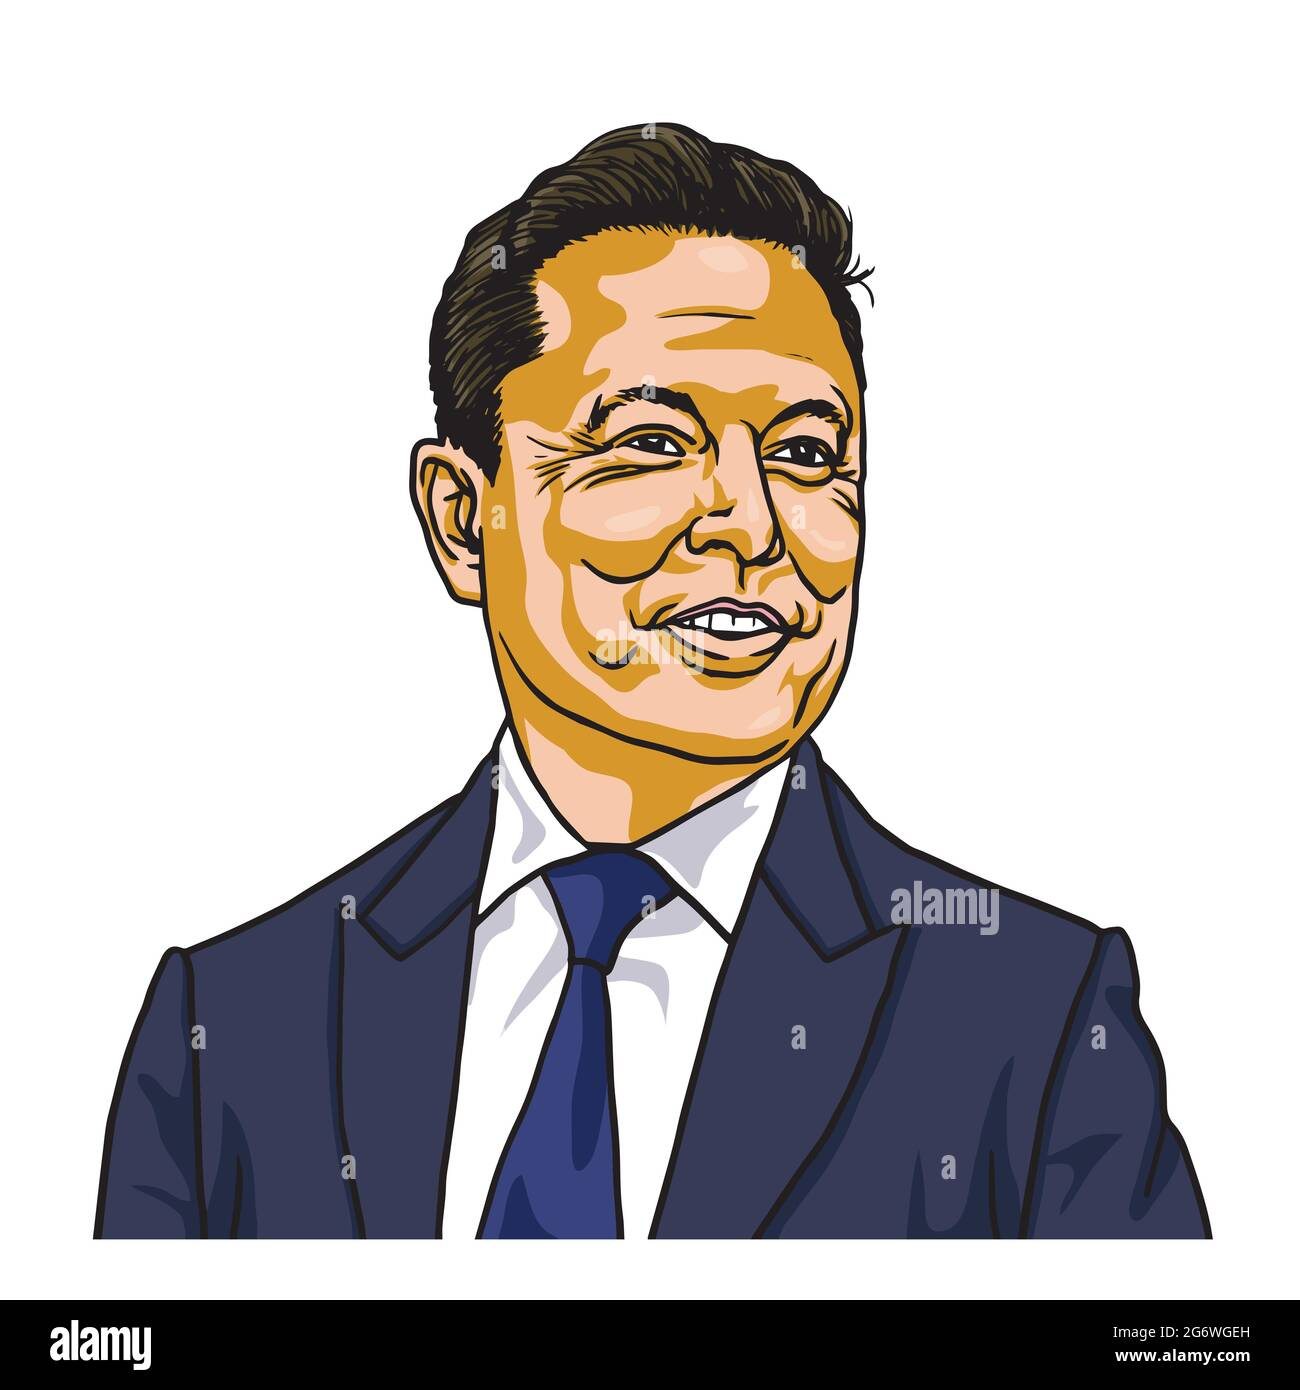

In [5]:
content_image = Image.open("Content.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

#### Content Cost Function $J_{content}(C,G)$
A method to achieve the first step is to calculate the content cost function, which will be defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

- Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 
- $a^{(C)}$ and $a^{(G)}$ are the hidden layer's activations (shape: [$n_H, n_W, n_C$]). 
- To compute the cost $J_{content}(C,G)$, we will unroll these 3D volumes into a 2D matrix (shape: [$n_H \times n_W, n_C$]).

In [6]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C),
    a_G -- tensor of dimension (1, n_H, n_W, n_C),
    
    Returns: 
    J_content -- scalar represented the content cost
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # We retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.shape
    new_shape = [int(m), int(n_H * n_W), int(n_C)]
    
    # We reshape a_C and a_G
    a_C_unrolled = tf.reshape(a_C, new_shape)
    a_G_unrolled = tf.reshape(a_G, new_shape)
    
    # We compute the cost with tensorflow
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))) / (4.0 * n_H * n_W * n_C)
    
    return J_content

In [7]:
# we content test the content cost and saw that it is equal to 0 when a_G is equals to a_C
tf.random.set_seed(1)
a_C = tf.random.normal([1, 1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost(a_C, a_G)
J_content_0 = compute_content_cost(a_C, a_C)
print("J_content = " + str(J_content))
print("J_content_0 = " + str(J_content_0))

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)
J_content_0 = tf.Tensor(0.0, shape=(), dtype=float32)


### 2 - Style Cost

We will use the following style image as exemple: 

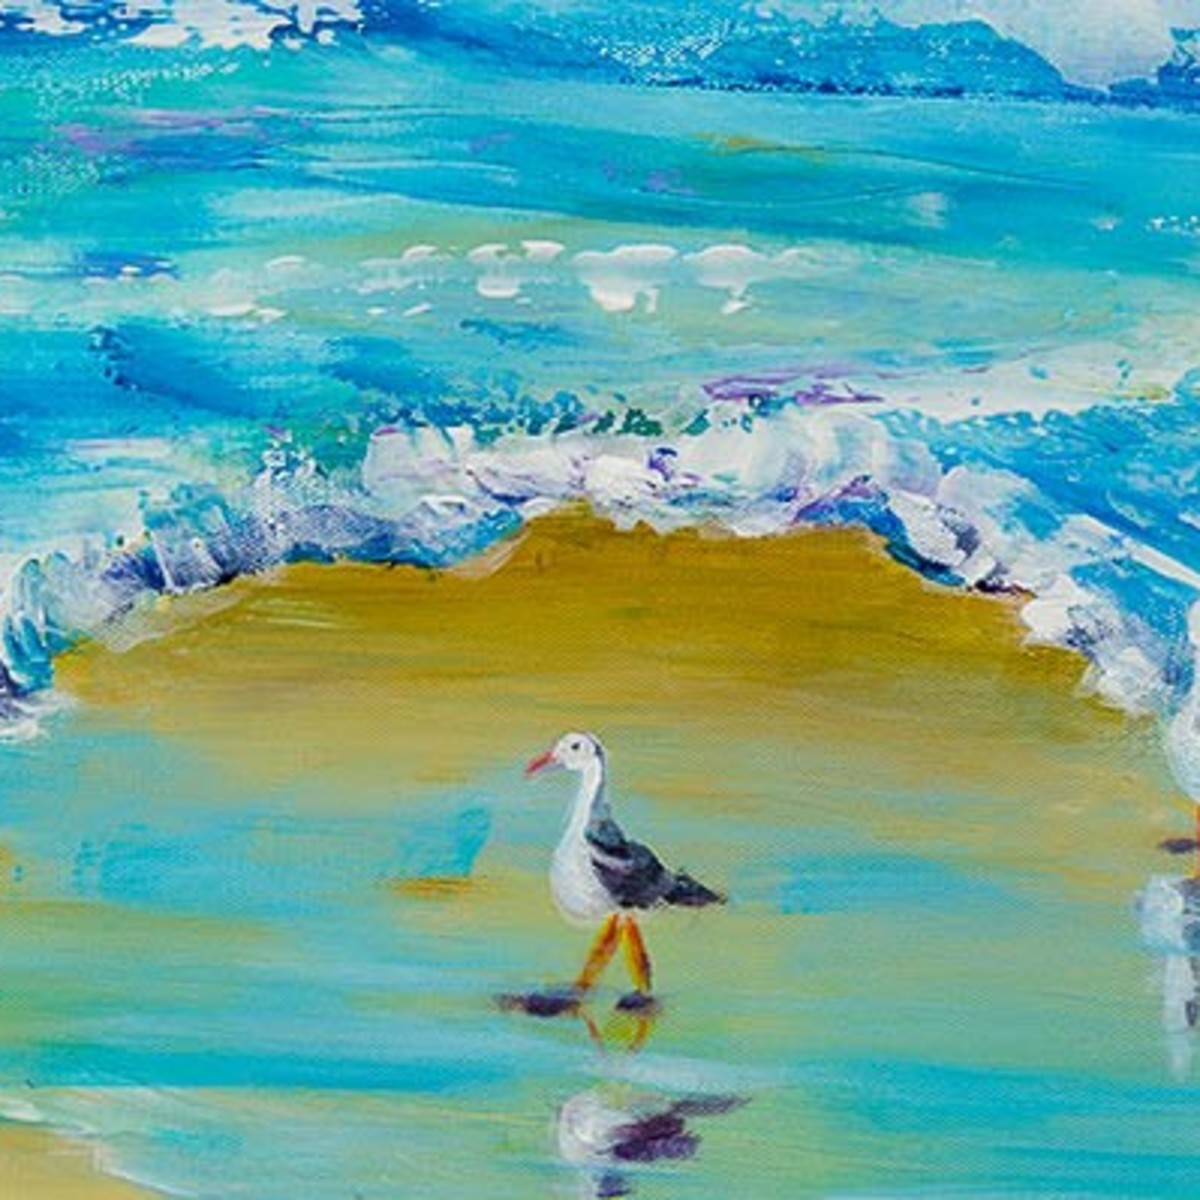

In [8]:
example = Image.open("Style.jpg")
example

#### Style Matrix
##### Gram matrix
The style matrix is also called a "Gram matrix."  
It is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$.  
In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, we expect them to have a large dot product, and thus for $G_{ij}$ to be large.  
For the sake of clarity, $G_{gram}$ will be used to refer to the Gram matrix, and $G$ to denote the generated image.  

##### Compute Gram matrix $G_{gram}$
We will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:
$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$  

##### $G_{(gram)ij}$: correlation
The result is a matrix of dimension $(n_C, n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$.  

##### $G_{(gram),ii}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, if filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 

In [9]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [10]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)
print("GA = \n" + str(GA))

GA = 
tf.Tensor(
[[ 63.1888    -26.721275   -7.7320204]
 [-26.721275   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)


#### Style Cost
Now we will try to minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G.  
exemple for a single hidden layer $a^{[l]}$ :  
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$
* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.

In [11]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C),
    a_G -- tensor of dimension (1, n_H, n_W, n_C),
    
    Returns: 
    J_style_layer -- style cost defined by equation (2)
    """
    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # We reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W)
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))
    
    # Weompute gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Finally we compute the loss
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))
    
    return J_style_layer

In [12]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)

print("J_style_layer = " + str(J_style_layer_SG))
print("J_style_layer = " + str(J_style_layer_GG))

J_style_layer = tf.Tensor(14.017808, shape=(), dtype=float32)
J_style_layer = tf.Tensor(0.0, shape=(), dtype=float32)


#### Style Weights
Now we have to "merge" style costs from several different layers. Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style. By default, each layer have an equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

This is the list of all layer names of our VGG-19

In [13]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [14]:
# The output of a layer block5_conv4 represent the image.
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv4')>

We can choose layers to represent the style of the image and assign style costs:

In [15]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

The following equation combine the style costs for different layers.
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 

In [16]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- style cost defined above by equation (2)
    """
    
    # We initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

__<ins>Recall:</ins>__  
Deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if we want the generated image to softly follow the style image, try choosing larger weights for deeper layers and smaller weights for the first layers. In contrast, if you want the generated image to strongly follow the style image, try choosing smaller weights for deeper layers and larger weights for the first layers.

### 3 - Defining the Total Cost to Optimize
Finally, we will create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [17]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha * J_content + beta * J_style

    return J

In [18]:
J_content = 0.2    
J_style = 0.8
J = total_cost(J_content, J_style)

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))

print("\033[92mAll tests passed")

J = tf.Tensor(32.9832, shape=(), dtype=float32)
All tests passed


## Optimization
**<ins>Recap:</ins>**  
Here are all steps to implement Neural Style Transfer.
1. Load the content image 
2. Load the style image
3. Randomly initialize the image to be generated 
4. Load the VGG19 model
5. Compute the content cost
6. Compute the style cost
7. Compute the total cost
8. Define the optimizer and learning rate

### Load the Content Image

(1, 400, 400, 3)


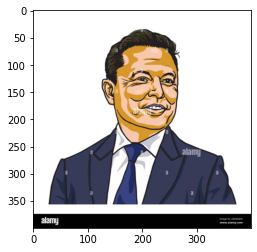

In [19]:
content_image = np.array(Image.open("Content.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

### Load the Style Image

(1, 400, 400, 3)


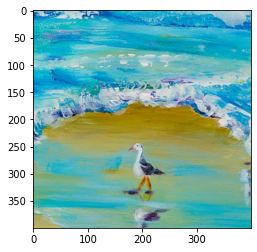

In [20]:
style_image =  np.array(Image.open("Style.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

### Randomly Initialize the Image to be Generated
We have to initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 

(1, 400, 400, 3)


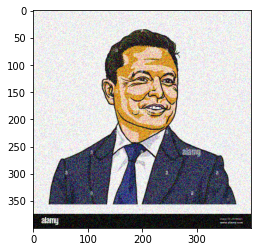

In [21]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

### Load the VGG19 model (pre-trained)
We define a function which loads the VGG19 model and returns a list of the outputs for the middle layers.

In [22]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Define the content layer and build the model.

In [23]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [24]:
print(vgg_model_outputs)

We are saving the outputs for the content and style layers in separate variables.

In [25]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

### Compute Total Cost

#### Compute the Content image Encoding (a_C)

We have built the model, and now to compute the content cost, we will encode our content image using the appropriate hidden layer activations. We will set this encoding to the variable `a_C`. We will use layer `block5_conv4` to compute the encoding.

In [26]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

#### Compute the Style image Encoding (a_S) 

We are doing the same with a_S giving the hidden layer activation for `STYLE_LAYERS` using our style image.

In [27]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

##### Utils

In [28]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

##### hyperparameters

In [29]:
LEARNING_RATE = 0.01
ALPHA = 10
BETA = 40

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [31]:
@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # we use the precomputed encoded images a_S and a_C
        # and compute a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(generated_image)
        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style, alpha = ALPHA, beta = BETA)
        
    grad = tape.gradient(J, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

In [32]:
generated_image = tf.Variable(generated_image)
J1 = train_step(generated_image)
print(J1)
J2 = train_step(generated_image)
print(J2)

tf.Tensor(18717.828, shape=(), dtype=float32)
tf.Tensor(12183.053, shape=(), dtype=float32)


### Train the Model
We can now generate an artistic image.

In [33]:
EPOCHS = 15000

Epoch 0 


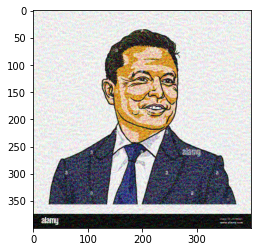

In [ ]:
# Show the generated image at some epochs
epochs = EPOCHS
for i in range(epochs):
    train_step(generated_image)
    if i % 1000 == 0:
        print(f"Epoch {i} ")
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

#### Result

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

## Class
Now we will create a class that contain all our functions

In [ ]:
class Model():
    def __init__(
        self,
        trainable=False,
        img_size = 400,
        weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
        model_type='vgg'
    ):
        self.img_size = img_size
        self.weights = weights
        self.trainable = trainable
        self.model = tf.keras.applications.VGG19(
            include_top=False,
            input_shape=(img_size, img_size, 3),
            weights=weights
        ) if model_type == 'vgg' tf.keras.applications.mobilenet_v2.MobileNetV2(
            input_shape=(img_size, img_size, 3),
            alpha=1.0,
            include_top=False,
            weights=weights,
            input_tensor=None,
            pooling=None,
            classes=1000,
            classifier_activation='softmax'
        )
    
    # Define the size of the image
    @property
    def img_size(self):
        return self._img_size

    @img_size.setter
    def img_size(self, img_size):
        self._img_size = img_size

    # Define the path of the pretrained weights
    @property
    def weights(self):
        return self._weights

    @weights.setter
    def weights(self, weights):
        self._weights = weights
    
    # Define the model mode
    @property
    def trainable(self):
        return self._trainable

    @trainable.setter
    def trainable(self, trainable):
        self._trainable = trainable
    
    # Define the model
    @property
    def model(self):
        return self._model

    @model.setter
    def model(self, model):
        self._model = model
        self._model.trainable = False
    
    # Method to display the layers of the current model
    def display_layer(self):
        for layer in self.model.layers:
            print(layer.name)

In [ ]:
class NST(Model):
    def __init__(
        self,
        trainable=False,
        img_size = 400,
        weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
        model_type='vgg'
        style_layers=[
            ('block1_conv1', 0.2),
            ('block2_conv1', 0.2),
            ('block3_conv1', 0.2),
            ('block4_conv1', 0.2),
            ('block5_conv1', 0.2)
        ],
        alpha = 10,
        beta = 40,
        path_content_image = "images/louvre_small.jpg",
        path_style_image = "images/monet.jpg",
        generated_image_threshold = 0.25,
        display_images = False,
        content_layer = [('block5_conv4', 1)],
        learning_rate = 0.01,
        optimizer = tf.keras.optimizers.Adam,
        epochs = 1001,
        output_folder = "output"
    ):
        super().__init__(trainable, img_size, weights)
        self.style_layers = style_layers
        # alpha -- hyperparameter weighting the importance of the content cost
        # beta -- hyperparameter weighting the importance of the style cost
        self.alpha = alpha
        self.beta = beta
        self.display_images = display_images
        self.content_image = self.load_image(path_content_image, 'Content image')
        self.style_image = self.load_image(path_style_image, 'Style image')
        self.generated_image = generated_image_threshold
        self.content_layer = content_layer
        self.model_outputs = self.style_layers + self.content_layer
        self.init_content_target() # Content encoder
        self.init_style_targets() # Style enconder
        self.init_a_C()
        self.init_a_S()
        self.learning_rate = 0.01
        self.optimizer = optimizer
        self.epochs = epochs
        self.output_folder = output_folder
    
    # Define all the layers and their weight du
    @property
    def style_layers(self):
        return self._style_layers

    @style_layers.setter
    def style_layers(self, style_layers):
        self._style_layers = style_layers
    
    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self, alpha):
        self._alpha = alpha
    
    @property
    def beta(self):
        return self._beta

    @beta.setter
    def beta(self, beta):
        self._beta = beta
    
    @property
    def content_image(self):
        return self._content_image

    @content_image.setter
    def content_image(self, content_image):
        self._content_image = content_image
        
    @property
    def style_image(self):
        return self._style_image

    @style_image.setter
    def style_image(self, style_image):
        self._style_image = style_image
        
    @property
    def generated_image(self):
        return self._generated_image

    @generated_image.setter
    def generated_image(self, threshold):
        self._generated_image = tf.Variable(self.init_generated_image(threshold = 0.25))
    
    @property
    def display_images(self):
        return self._display_images

    @display_images.setter
    def display_images(self, display_images):
        self._display_images = display_images
    
    @property
    def content_layer(self):
        return self._content_layer

    @content_layer.setter
    def content_layer(self, content_layer):
        self._content_layer = content_layer
        
    @property
    def model_outputs(self):
        return self._model_outputs

    @model_outputs.setter
    def model_outputs(self, layers):
        self._model_outputs = self.get_layer_outputs(layers)
        
    @property
    def content_target(self):
        return self._content_target

    def init_content_target(self):
        self._content_target = self.model_outputs(self.content_image)
        
    @property
    def style_targets(self):
        return self._style_targets

    def init_style_targets(self):
        self._style_targets = self.model_outputs(self.style_image)
        
    @property
    def a_C(self):
        return self._a_C

    def init_a_C(self):
        # Assign the content image to be the input of the model.  
        # Set a_C to be the hidden layer activation from the layer we have selected
        preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(self.content_image, tf.float32))
        self._a_C = self.model_outputs(preprocessed_content)
        
    @property
    def a_S(self):
        return self._a_S

    def init_a_S(self):
        # Assign the input of the model to be the "style" image
        preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(self.style_image, tf.float32))
        self._a_S = self.model_outputs(preprocessed_style)
        
    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        self._learning_rate = learning_rate
    
    @property
    def optimizer(self):
        return self._optimizer

    @optimizer.setter
    def optimizer(self, optimizer):
        self._optimizer = optimizer(learning_rate=self.learning_rate)
    
    @property
    def epochs(self):
        return self._epochs

    @epochs.setter
    def epochs(self, epochs):
        self._epochs = epochs
    
    @property
    def output_folder(self):
        return self._output_folder

    @output_folder.setter
    def output_folder(self, output_folder):
        self._output_folder = output_folder
        
    def compute_content_cost(self, content_output, generated_output):
        """
        Computes the content cost

        Arguments:
        a_C -- tensor of dimension (1, n_H, n_W, n_C),
        a_G -- tensor of dimension (1, n_H, n_W, n_C),

        Returns: 
        J_content -- scalar represented the content cost
        """
        a_C = content_output[-1]
        a_G = generated_output[-1]

        # We retrieve dimensions from a_G
        m, n_H, n_W, n_C = a_G.shape
        new_shape = [int(m), int(n_H * n_W), int(n_C)]

        # We reshape a_C and a_G
        a_C_unrolled = tf.reshape(a_C, new_shape)
        a_G_unrolled = tf.reshape(a_G, new_shape)

        # We compute the cost with tensorflow
        J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))) / (4.0 * n_H * n_W * n_C)

        return J_content

    def gram_matrix(self, A):
        """
        Argument:
        A -- matrix of shape (n_C, n_H*n_W)

        Returns:
        GA -- Gram matrix of A, of shape (n_C, n_C)
        """  
        GA = tf.matmul(A, tf.transpose(A))
        return GA
    
    def compute_layer_style_cost(self, a_S, a_G):
        """
        Arguments:
        a_S -- tensor of dimension (1, n_H, n_W, n_C),
        a_G -- tensor of dimension (1, n_H, n_W, n_C),

        Returns: 
        J_style_layer -- style cost defined by equation (2)
        """
        # Retrieve dimensions from a_G
        _, n_H, n_W, n_C = a_G.get_shape().as_list()

        # We reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W)
        a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
        a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

        # Weompute gram_matrices for both images S and G
        GS = self.gram_matrix(a_S)
        GG = self.gram_matrix(a_G)

        # Finally we compute the loss
        J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))

        return J_style_layer
        
    def compute_style_cost(self, style_image_output, generated_image_output):
        """
        Computes the overall style cost from several chosen layers

        Arguments:
        style_image_output -- our tensorflow model
        generated_image_output --

        Returns: 
        J_style -- style cost defined above by equation (2)
        """

        # We initialize the overall style cost
        J_style = 0

        # Set a_S to be the hidden layer activation from the layer we have selected.
        # The last element of the array contains the content layer image, which must not be used.
        a_S = style_image_output[:-1]

        # Set a_G to be the output of the choosen hidden layers.
        # The last element of the list contains the content layer image which must not be used.
        a_G = generated_image_output[:-1]
        for i, weight in zip(range(len(a_S)), self.style_layers):  
            # Compute style_cost for the current layer
            J_style_layer = self.compute_layer_style_cost(a_S[i], a_G[i])

            # Add weight * J_style_layer of this layer to overall style cost
            J_style += weight[1] * J_style_layer

        return J_style
    
    @tf.function()
    def total_cost(self, J_content, J_style):
        """
        Computes the total cost function

        Arguments:
        J_content -- content cost coded above
        J_style -- style cost coded above

        Returns:
        J -- total cost as defined by the formula above.
        """
        J = self.alpha * J_content + self.beta * J_style
        return J
    
    def load_image(self, path, title = ''):
        image = np.array(Image.open(path).resize((self.img_size, self.img_size)))
        image = tf.constant(np.reshape(image, ((1,) + image.shape)))
        
        if (self.display_images):
            print(image.shape)
            plt.title(title)
            imshow(image[0])
            plt.show()
        
        return image
        
    def init_generated_image(self, threshold = 0.25):
        generated_image = tf.Variable(tf.image.convert_image_dtype(self.content_image, tf.float32))
        noise = tf.random.uniform(tf.shape(generated_image), -threshold, threshold)
        generated_image = tf.add(generated_image, noise)
        generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
        
        if (self.display_images):
            print(generated_image.shape)
            plt.title('Generated image')
            imshow(generated_image.numpy()[0])
            plt.show()
        return generated_image
        
    # init with
    def get_layer_outputs(self, layer_names):
        """ Creates a model that returns a list of intermediate output values."""
        outputs = [self.model.get_layer(layer[0]).output for layer in layer_names]

        model = tf.keras.Model([self.model.input], outputs)
        return model
    
    def clip_0_1(self, image):
        """
        Truncate all the pixels in the tensor to be between 0 and 1

        Arguments:
        image -- Tensor
        J_style -- style cost coded above

        Returns:
        Tensor
        """
        return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

    def tensor_to_image(self, tensor):
        """
        Converts the given tensor into a PIL image

        Arguments:
        tensor -- Tensor

        Returns:
        Image: A PIL image
        """
        tensor = tensor * 255
        tensor = np.array(tensor, dtype=np.uint8)
        if np.ndim(tensor) > 3:
            assert tensor.shape[0] == 1
            tensor = tensor[0]
        return Image.fromarray(tensor)
    
    @tf.function()
    def train_step(self, generated_image):
        with tf.GradientTape() as tape:
            # we use the precomputed encoded images a_S and a_C
            # and compute a_G as the model_outputs for the current generated image
            a_G = self.model_outputs(generated_image)
            # Compute the style cost
            J_style = self.compute_style_cost(self.a_S, a_G)
            # Compute the content cost
            J_content = self.compute_content_cost(self.a_C, a_G)
            # Compute the total cost
            J = self.total_cost(J_content, J_style)

        grad = tape.gradient(J, generated_image)
        self.optimizer.apply_gradients([(grad, generated_image)])
        generated_image.assign(self.clip_0_1(generated_image))
        # For grading purposes
        return J
        
    # Show the generated image at some epochs
    # Uncoment to reset the style transfer process. You will need to compile the train_step function again 
    def fit(self, preview = False, save_step = 250):
        assert save_step > 250, 'Should be at least greater then 250'        
        for i in trange(self.epochs, desc='Epochs', ncols=500):
            self.train_step(self.generated_image)
            if i % save_step == 0:
                # checking if folder exist
                os.makedirs(f"./{self.output_folder}", exist_ok=True)
                image = self.tensor_to_image(self.generated_image)
                image.save(f"{self.output_folder}/image_{i}.jpg")
                if preview:
                    imshow(image)
                    plt.show()
            
    # Show the 3 images in a row
    def display_full_result(self):
        fig = plt.figure(figsize=(16, 4))
        ax = fig.add_subplot(1, 3, 1)
        imshow(self.content_image[0])
        ax.title.set_text('Content image')
        ax = fig.add_subplot(1, 3, 2)
        imshow(self.style_image[0])
        ax.title.set_text('Style image')
        ax = fig.add_subplot(1, 3, 3)
        imshow(self.generated_image[0])
        ax.title.set_text('Generated image')
        plt.show()
    
    def load_output_files_names(self, path = 'output'):
        onlyfiles = [re.split('[_.]', f) for f in listdir(path) if isfile(join(path, f))]
        onlyfiles.sort(key=lambda x: int(x[1]))
        return [f"{f[0]}_{f[1]}.{f[2]}" for f in onlyfiles]
        
    def result_preview(self):
        # init the plot
        fig, axes = plt.subplots()
        # retrieve all files names
        output_images_path = self.load_output_files_names(self.output_folder)
        # display the first image
        axes.imshow(Image.open(f"./{self.output_folder}/{output_images_path[0]}"))
        # create the slider button
        slider=wd.IntSlider(
            value=0, #intial image index
            min=0,
            max=len(output_images_path)-1,
        )
        # create the play button
        play_button=wd.Play(
            value=0, #intial image index
            min=0,
            max=len(output_images_path)-1,
            step=1,
            interval=200, #referesh interval in ms
            description="Press play",
        )
        wd.jslink((play_button,"value"),(slider,"value"))

        def slider_update(change):
            img = Image.open(rf"./{self.output_folder}/{output_images_path[change.new]}")
            axes.imshow(img)
            fig.canvas.draw_idle()
            plt.suptitle(f'Time: {slider.value}')
        slider.observe(slider_update, "value")
        out=wd.Output()
        app=wd.VBox([wd.HBox([play_button,slider]),out])
        display(app)

In [ ]:
%matplotlib inline
nst = NST(
    display_images = False,
    epochs = 5001,
    output_folder = 'output_v1/10_0_0_0_0',
    style_layers=[
        ('block1_conv1', 1),
        ('block2_conv1', 0),
        ('block3_conv1', 0),
        ('block4_conv1', 0),
        ('block5_conv1', 0)
    ]
)

In [ ]:
nst.fit(save_step=1000)

In [ ]:
nst.display_full_result()

In [ ]:
%matplotlib widget
nst.result_preview()

------

### Styles layers Testing configurations
In the following cell we tested different configurations for the style layers in order to highlight their respective impact on the generated image.  
We named the generated images according to the weight of the layers, with a value between $0e^{-1}$ and $10e^{-1}$.  
ex:  
**10_0_0_0_0 =**
```python
[
    ('block1_conv1', 1),
    ('block2_conv1', 0),
    ('block3_conv1', 0),
    ('block4_conv1', 0),
    ('block5_conv1', 0)
]
```
**2_2_2_2_2 =**
```python
[
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)
]
```

In [ ]:
%matplotlib inline
first_fig = ['10_0_0_0_0', '0_10_0_0_0', '0_0_10_0_0', '0_0_0_10_0', '0_0_0_0_10']
second_fig = ['5_5_0_0_0', '0_5_5_0_0', '0_0_5_5_0', '0_0_0_5_5', '5_0_0_0_5']
third_fig = ['4_4_2_0_0', '0_4_4_2_0', '0_0_4_4_2', '2_0_0_4_4', '4_2_0_0_4']
fourth_fig = ['1_4_4_1_0', '0_1_4_4_1', '1_0_1_4_4', '4_1_0_1_4', '4_4_1_0_1']
fifth_fig = ['3_3_3_1_0', '0_3_3_3_1', '1_0_3_3_3', '3_1_0_3_3', '3_3_1_0_3']

total_fig = first_fig + second_fig + third_fig + fourth_fig + fifth_fig

fig = plt.figure(figsize=(32, 32))
fig.tight_layout()
for i in range(len(total_fig)):
    ax = fig.add_subplot(5, 5, (i + 1))
    imshow(Image.open(f"./output/{total_fig[i]}/image_10000.jpg"))
    ax.title.set_text(total_fig[i])
    ax.axis('off')
# plt.savefig('output/5x5.png')
plt.show()

In [ ]:
%matplotlib inline
nst = NST(
    display_images = False,
    epochs = 20001,
    path_content_image = "images/tour_eiffel.jpg",
    path_style_image = "images/starry_night.jpg",
    output_folder = 'output_v1/4_4_1_0_1',
    style_layers=[
        ('block1_conv1', 0.4),
        ('block2_conv1', 0.4),
        ('block3_conv1', 0.1),
        ('block4_conv1', 0),
        ('block5_conv1', 0.1)
    ]
)
nst.fit(save_step=2000)
nst.display_full_result()

---
### MobileNetV2

In [ ]:
%matplotlib inline
nst = NST(
    weights='imagenet',
    model_type='mobileNet'
    display_images = False,
    epochs = 5001,
    output_folder = 'output_v1/10_0_0_0_0',
    style_layers=[
        ('block_1_project_BN', 0.0625),
        ('block_2_project_BN', 0.0625),
        ('block_3_project_BN', 0.0625),
        ('block_4_project_BN', 0.0625),
        ('block_5_project_BN', 0.0625),
        ('block_6_project_BN', 0.0625),
        ('block_7_project_BN', 0.0625),
        ('block_8_project_BN', 0.0625),
        ('block_9_project_BN', 0.0625),
        ('block_10_project_BN', 0.0625),
        ('block_11_project_BN', 0.0625),
        ('block_12_project_BN', 0.0625),
        ('block_13_project_BN', 0.0625),
        ('block_14_project_BN', 0.0625),
        ('block_15_project_BN', 0.0625),
        ('block_16_project_BN', 0.0625)
    ]
)
nst.fit(save_step=1000)
nst.display_full_result()

In [ ]:
mobileNet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=None,
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

In [ ]:
for layer in mobileNet.layers:
    print(layer.name)